In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd



class velocity_net(nn.Module):
    def __init__(self,d):
        super().__init__()
        hidden_unit=32
        self.d=d
        self.net=nn.Sequential(
            nn.Linear(d+1,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,d,bias=False),
        )
        
        # for module in self.net.modules():
        #     if isinstance(module, nn.Linear):
        #         # init.zeros_(module.weight)
        #         init.normal_(module.weight, mean=0, std=0.1)

    def forward(self,x):
        # return  x[:,:self.d]
        return  self.net(x)




torch.Size([5000, 1])


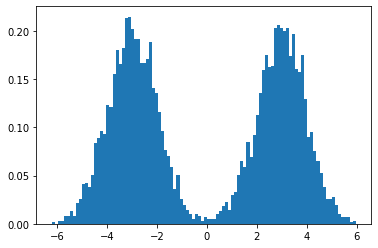

In [12]:
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)[:5000,:]
print(data.shape)
plt.hist(data.cpu().numpy(),bins=100,density=True)
plt.show()

In [13]:
###ODE solver
def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z += (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z += (2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z += (1.0/6.0) * K
    return z

def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z += (t1 - t0) * odefun(z0, t0, net)
    return z




def odefun(x, t, net):
    nex, d = x.shape
    z = pad(x[:, :d], (0, 1, 0, 0), value=t) # concatenate with the time t
    dx = net(z)
    # dx=x
    return dx


def odefun_score_log(score_x, x, t, net, device):
    # z=zFull[:,:,nt-k]#
    nex, d = x.shape
    divergence=torch.zeros(x.shape[0],device=device)
    z = pad(x, (0, 1, 0, 0), value=t) # concatenate with the time t
    z.requires_grad_(True)

    for i in range(d):
        grad = autograd.grad(net(z)[:,i].sum(), z, create_graph=True,retain_graph=True)[0][:,i]

        # divergence+= grad.detach()
        divergence+= grad


    grad_div_f=autograd.grad(divergence.sum(), z, create_graph=True,retain_graph=True)[0][:,i]
    #calculate jacobbian 这里是一维 暂时没有问题
    for i in range(d):
        jacobian = autograd.grad(net(z)[:,i].sum(), z, create_graph=True,retain_graph=True)[0][:,i]

    d_score=(-grad_div_f-jacobian*score_x.squeeze()).reshape(-1,1)
    d_log=-divergence
    return d_score,d_log






In [14]:
def Gaussian_1d(x,mu=0,sigma=1):
    return 1/(math.sqrt(2*math.pi*sigma**2))*torch.exp(-(x-mu)**2/2/sigma**2)

def grad_log_Gaussian(x,mu=0,sigma=1):
    return -(x-mu)/sigma**2

def mix_gau_1d(x):
    # 0.5*N(-3,1)+0.5*N(3,1)
    return 0.5*Gaussian_1d(x,mu=-3)+0.5*Gaussian_1d(x,mu=3)

def grad_mix_gau(x):
    return 1/mix_gau_1d(x)*(-0.5*Gaussian_1d(x,mu=-3)*(x+3)-0.5*Gaussian_1d(x,mu=3)*(x-3))


# x=torch.linspace(-50,50,100)
# plt.plot(x,Gaussian_1d(x),color="blue")
# plt.plot(x,mix_gau_1d(x),color="yellow")
# plt.plot(x,grad_mix_gau(x),color="blue")
# plt.plot(x,grad_log_Gaussian(x),color="red")

In [15]:
import tqdm
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
f_theta = velocity_net(d=1).to(device)
# f_theta= Phi(nTh=2, m=32, d=1).to(device)


batch_size=64
# data=data.to(device)
label=torch.ones(data.shape[0],1)
dataset = TensorDataset(data,label)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_epochs=5
tqdm_epoch = tqdm.trange(n_epochs)



rho_logrho=torch.mean(torch.log(mix_gau_1d(data)))

optim = torch.optim.Adam(f_theta.parameters(), lr=1e-2)
tspan=[0,1]
nt=8
h = (tspan[1]-tspan[0]) / nt







  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
#plot
def plot_zfull(zFull):
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    axs[0,0].hist(zFull[:,:,0].detach().cpu().numpy(),bins=100,density=True)
    axs[0,1].hist(zFull[:,:,1].detach().cpu().numpy(),bins=100,density=True)
    axs[0,2].hist(zFull[:,:,2].detach().cpu().numpy(),bins=100,density=True)
    axs[1,0].hist(zFull[:,:,3].detach().cpu().numpy(),bins=100,density=True)
    axs[1,1].hist(zFull[:,:,4].detach().cpu().numpy(),bins=100,density=True)
    axs[1,2].hist(zFull[:,:,5].detach().cpu().numpy(),bins=100,density=True)
    axs[2,0].hist(zFull[:,:,6].detach().cpu().numpy(),bins=100,density=True)
    axs[2,1].hist(zFull[:,:,7].detach().cpu().numpy(),bins=100,density=True)
    axs[2,2].hist(zFull[:,:,8].detach().cpu().numpy(),bins=100,density=True)
    x_space=torch.linspace(-5,5,100)
    axs[2,2].plot(x_space,Gaussian_1d(x_space),color="red")
    plt.tight_layout()
    plt.show()

def plot_scoreFull(zFull,score_Full):
#plot score
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    axs[0,0].scatter(zFull[:,:,0].detach().cpu().numpy(),score_Full[:,:,8].detach().cpu().numpy(),s=1)
    axs[0,1].scatter(zFull[:,:,1].detach().cpu().numpy(),score_Full[:,:,7].detach().cpu().numpy(),s=1)
    axs[0,2].scatter(zFull[:,:,2].detach().cpu().numpy(),score_Full[:,:,6].detach().cpu().numpy(),s=1)
    axs[1,0].scatter(zFull[:,:,3].detach().cpu().numpy(),score_Full[:,:,5].detach().cpu().numpy(),s=1)
    axs[1,1].scatter(zFull[:,:,4].detach().cpu().numpy(),score_Full[:,:,4].detach().cpu().numpy(),s=1)
    axs[1,2].scatter(zFull[:,:,5].detach().cpu().numpy(),score_Full[:,:,3].detach().cpu().numpy(),s=1)
    axs[2,0].scatter(zFull[:,:,6].detach().cpu().numpy(),score_Full[:,:,2].detach().cpu().numpy(),s=1)
    axs[2,1].scatter(zFull[:,:,7].detach().cpu().numpy(),score_Full[:,:,1].detach().cpu().numpy(),s=1)
    axs[2,2].scatter(zFull[:,:,8].detach().cpu().numpy(),score_Full[:,:,0].detach().cpu().numpy(),s=1)
    x_space=torch.linspace(-5,5,100)
    axs[2,2].plot(x_space,grad_log_Gaussian(x_space),color="red")
    axs[0,0].plot(x_space,grad_mix_gau(x_space),color="red")


    plt.tight_layout()
    plt.show()

In [17]:
loss_record=[]

for epoch in tqdm_epoch:
    for batch ,label in data_loader:
    #sampling
       
        batch=batch.to(device)
        zFull = torch.zeros(*batch.shape , nt+1, device=batch.device, dtype=batch.dtype) # make tensor of size z.shape[0], z.shape[1], nt
        zFull[:,:,0] = batch
        tk=0
        
        for k in  range(nt):
            zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , f_theta, tk, tk+h)
            tk += h


        #backward for \nabla log rho
        z_terminal=zFull[:,:,-1]
        grad_terminal=grad_log_Gaussian(z_terminal)
        score_Full=grad_terminal.unsqueeze(2)


        log_terminal=torch.log(Gaussian_1d(z_terminal))
        log_Full=log_terminal



        tk=tspan[1]
        for k in  range(nt):
            

            d_score,d_log=odefun_score_log(score_Full[:,:,-1], zFull[:,:,nt-k], tk, net=f_theta,device=device)
            new_score=score_Full[:,:,-1]+(-h)*d_score
            new_log=log_Full[:,-1]+(-h)*d_log
            score_Full=torch.cat((score_Full,new_score.unsqueeze(2)),dim=2)
            log_Full=torch.cat((log_Full,new_log.unsqueeze(1)),dim=1)
            tk-=h




        optim.zero_grad()
        loss=0
        for k in  range(nt+1):
            tk=h*k
            x=zFull[:,:,k]
            z = pad(x, (0, 1, 0, 0), value=tk) # concatenate with the time t
            # loss=loss+torch.mean( (score_Full[:,:,nt-k]+f_theta(z))**2)+ torch.mean(score_Full[:,:,nt-k]*f_theta(z))
            loss+=torch.mean( (score_Full[:,:,nt-k]+f_theta(z))**2)*h*0.1
        loss=loss-torch.mean(log_Full[:,-1])
        loss.backward()
        optim.step()
        loss_record.append((-torch.mean(log_Full[:,-1])+rho_logrho).detach().cpu())
    torch.save(f_theta.state_dict(), 'ckpt.pth')







100%|██████████| 5/5 [01:02<00:00, 12.54s/it]


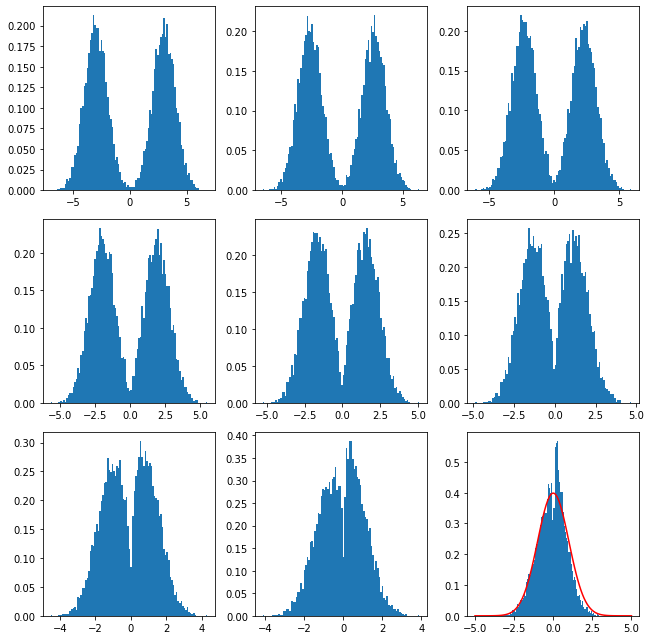

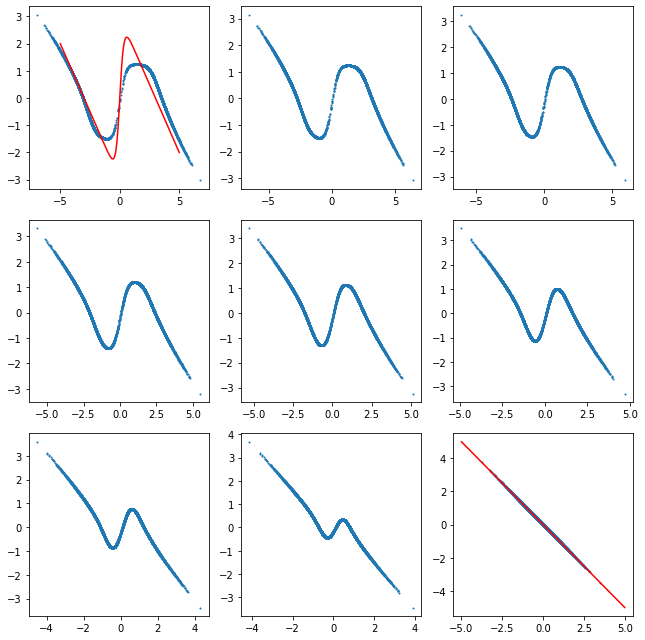

In [18]:
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)
data=data.to(device)
zFull = torch.zeros(*data.shape , nt+1, device=data.device, dtype=data.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = data
tk=0

for k in  range(nt):
    zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , f_theta, tk, tk+h)
    tk += h

z_terminal=zFull[:,:,-1]
grad_terminal=grad_log_Gaussian(z_terminal)
score_Full=grad_terminal.unsqueeze(2)


log_terminal=torch.log(Gaussian_1d(z_terminal))
log_Full=log_terminal



tk=tspan[1]
for k in  range(nt):
    

    d_score,d_log=odefun_score_log(score_Full[:,:,-1], zFull[:,:,nt-k], tk, net=f_theta,device=device)
    new_score=score_Full[:,:,-1]+(-h)*d_score
    new_log=log_Full[:,-1]+(-h)*d_log
    score_Full=torch.cat((score_Full,new_score.unsqueeze(2)),dim=2)
    log_Full=torch.cat((log_Full,new_log.unsqueeze(1)),dim=1)
    tk-=h


plot_zfull(zFull)
plot_scoreFull(zFull,score_Full)

No handles with labels found to put in legend.


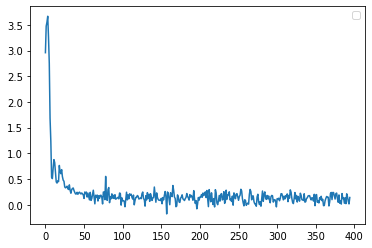

In [19]:
plt.plot(loss_record)
# plt.yscale("log")
plt.legend()
plt.show()